In [1]:
# This model is based on the keras tutorial on github
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

In [2]:
K.set_image_data_format('channels_first')

np.random.seed(1000)
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train.shape

(60000, 28, 28)

In [3]:
X_train = X_train.reshape(60000, 28*28)
print(X_train.shape)

(60000, 784)


In [4]:
adam = Adam(lr=0.0002, beta_1=0.5)

def Gan(randomDim=10, model_complexity=256):
  generator = Sequential()
  generator.add(Dense(model_complexity, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.002)))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(256))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(512))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(784, activation='tanh'))
  generator.compile(loss='binary_crossentropy', optimizer=adam)

  discriminator = Sequential()
  discriminator.add(Dense(512, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.002)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(128))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(1, activation='sigmoid'))
  discriminator.compile(loss='binary_crossentropy', optimizer=adam)

  discriminator.trainable = False
  generator_Input = Input(shape=(randomDim, ))
  x = generator(generator_Input)
  generator_output = discriminator(x)

  GAN = Model(inputs=generator_Input, outputs=generator_output)
  GAN.compile(loss='binary_crossentropy', optimizer=adam)
  return generator, discriminator, GAN 

In [5]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

In [6]:
# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10), generator=Sequential()):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    # plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

In [7]:
# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('models/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/gan_discriminator_epoch_%d.h5' % epoch)

In [8]:

def train(epochs=1, batchSize=128, randomDim=10, model_complexity=256):
    batchCount = X_train.shape[0] / batchSize
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)
    print('randomDim: ', randomDim)
    generator, discriminator, gan = Gan(randomDim=randomDim, model_complexity=model_complexity)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 10 == 0:
            plotGeneratedImages(e, generator=generator)
            # saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 50
Batch size: 128
Batches per epoch: 468.75
randomDim:  10
--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:20, 23.20it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:19, 23.80it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:19, 23.57it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:19, 24.12it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:18, 24.62it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:20, 23.21it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:20, 23.10it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:21, 21.61it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:21, 22.05it/s]

--------------- Epoch 10 ---------------


  1%|          | 3/468 [00:00<00:20, 23.02it/s]

--------------- Epoch 11 ---------------


  0%|          | 2/468 [00:00<00:23, 19.76it/s]

--------------- Epoch 12 ---------------


  1%|          | 3/468 [00:00<00:22, 20.77it/s]

--------------- Epoch 13 ---------------


  1%|          | 3/468 [00:00<00:20, 23.00it/s]

--------------- Epoch 14 ---------------


  1%|          | 3/468 [00:00<00:19, 23.28it/s]

--------------- Epoch 15 ---------------


  0%|          | 2/468 [00:00<00:23, 19.97it/s]

--------------- Epoch 16 ---------------


  1%|          | 3/468 [00:00<00:19, 23.69it/s]

--------------- Epoch 17 ---------------


  1%|          | 3/468 [00:00<00:20, 22.46it/s]

--------------- Epoch 18 ---------------


  1%|          | 3/468 [00:00<00:22, 20.32it/s]

--------------- Epoch 19 ---------------


  1%|          | 3/468 [00:00<00:18, 24.76it/s]

--------------- Epoch 20 ---------------


  1%|          | 3/468 [00:00<00:19, 24.22it/s]

--------------- Epoch 21 ---------------


  1%|          | 3/468 [00:00<00:20, 22.94it/s]

--------------- Epoch 22 ---------------


  1%|          | 3/468 [00:00<00:20, 23.10it/s]

--------------- Epoch 23 ---------------


  1%|          | 3/468 [00:00<00:19, 24.03it/s]

--------------- Epoch 24 ---------------


  1%|          | 3/468 [00:00<00:22, 20.66it/s]

--------------- Epoch 25 ---------------


  1%|          | 3/468 [00:00<00:19, 23.59it/s]

--------------- Epoch 26 ---------------


  1%|          | 3/468 [00:00<00:19, 24.41it/s]

--------------- Epoch 27 ---------------


  1%|          | 3/468 [00:00<00:19, 23.70it/s]

--------------- Epoch 28 ---------------


  1%|          | 3/468 [00:00<00:22, 21.09it/s]

--------------- Epoch 29 ---------------


  1%|          | 3/468 [00:00<00:19, 23.75it/s]

--------------- Epoch 30 ---------------


  1%|          | 3/468 [00:00<00:21, 21.63it/s]

--------------- Epoch 31 ---------------


  1%|          | 3/468 [00:00<00:19, 23.81it/s]

--------------- Epoch 32 ---------------


  1%|          | 3/468 [00:00<00:19, 24.17it/s]

--------------- Epoch 33 ---------------


  1%|          | 3/468 [00:00<00:24, 19.33it/s]

--------------- Epoch 34 ---------------


  1%|          | 3/468 [00:00<00:19, 23.83it/s]

--------------- Epoch 35 ---------------


  1%|          | 3/468 [00:00<00:21, 21.78it/s]

--------------- Epoch 36 ---------------


  1%|          | 3/468 [00:00<00:19, 23.69it/s]

--------------- Epoch 37 ---------------


  1%|          | 3/468 [00:00<00:20, 22.97it/s]

--------------- Epoch 38 ---------------


  1%|          | 3/468 [00:00<00:19, 23.29it/s]

--------------- Epoch 39 ---------------


  1%|          | 3/468 [00:00<00:18, 24.61it/s]

--------------- Epoch 40 ---------------


  1%|          | 3/468 [00:00<00:19, 23.44it/s]

--------------- Epoch 41 ---------------


  1%|          | 3/468 [00:00<00:21, 21.74it/s]

--------------- Epoch 42 ---------------


  1%|          | 3/468 [00:00<00:21, 21.92it/s]

--------------- Epoch 43 ---------------


  1%|          | 3/468 [00:00<00:19, 23.55it/s]

--------------- Epoch 44 ---------------


  1%|          | 3/468 [00:00<00:20, 22.86it/s]

--------------- Epoch 45 ---------------


  1%|          | 3/468 [00:00<00:21, 21.44it/s]

--------------- Epoch 46 ---------------


  1%|          | 3/468 [00:00<00:19, 24.24it/s]

--------------- Epoch 47 ---------------


  1%|          | 3/468 [00:00<00:20, 23.07it/s]

--------------- Epoch 48 ---------------


  1%|          | 3/468 [00:00<00:20, 22.73it/s]

--------------- Epoch 49 ---------------


  1%|          | 3/468 [00:00<00:19, 23.75it/s]

--------------- Epoch 50 ---------------


100%|██████████| 468/468 [00:20<00:00, 22.70it/s]


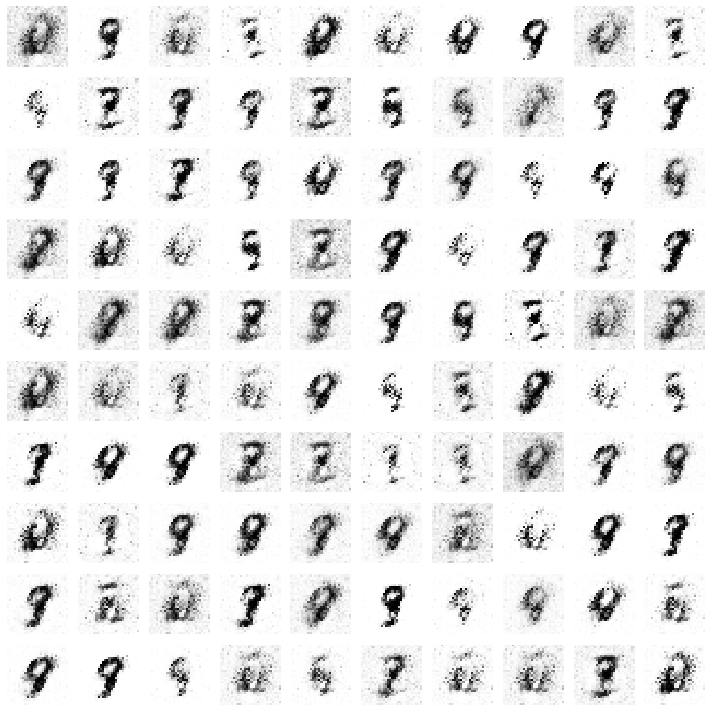

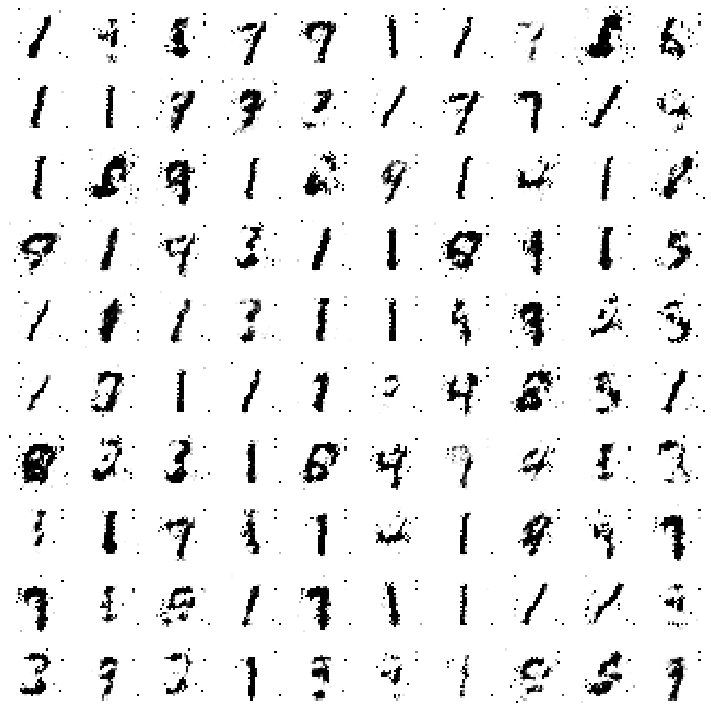

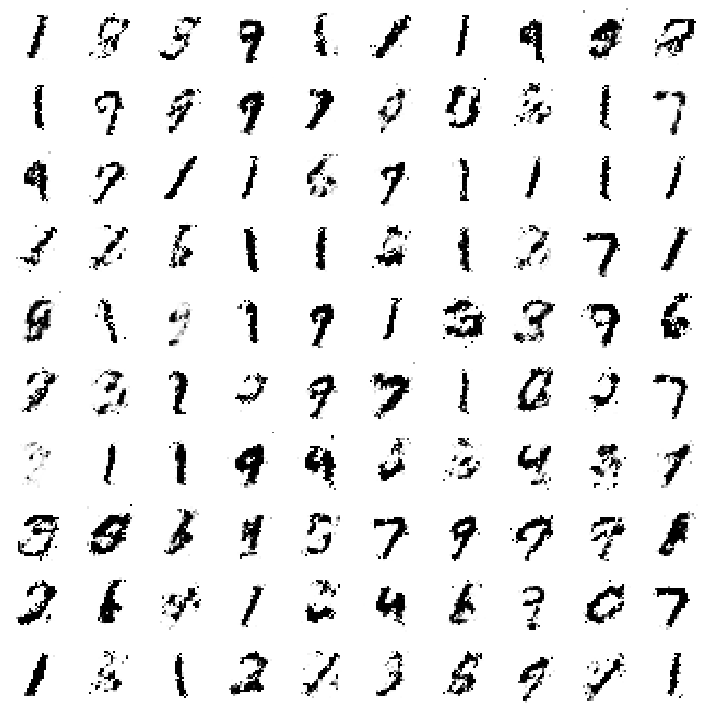

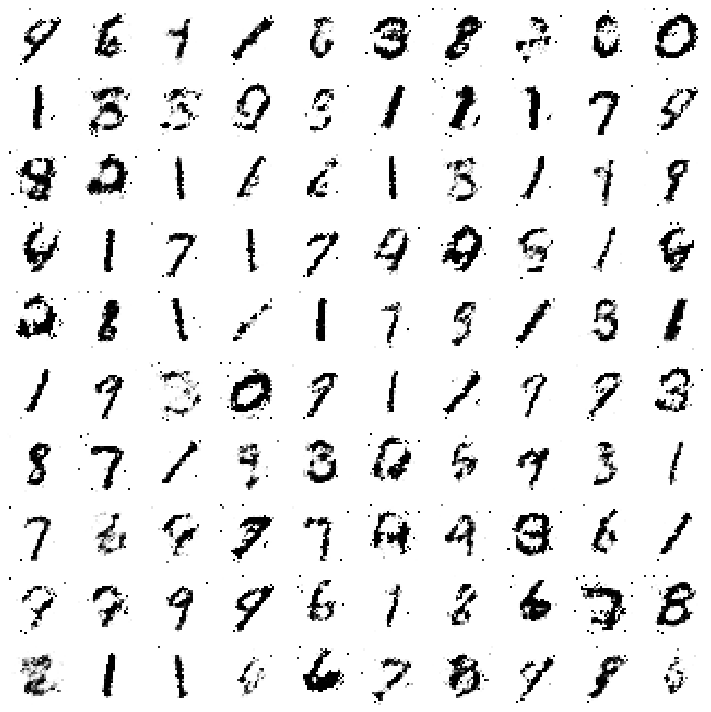

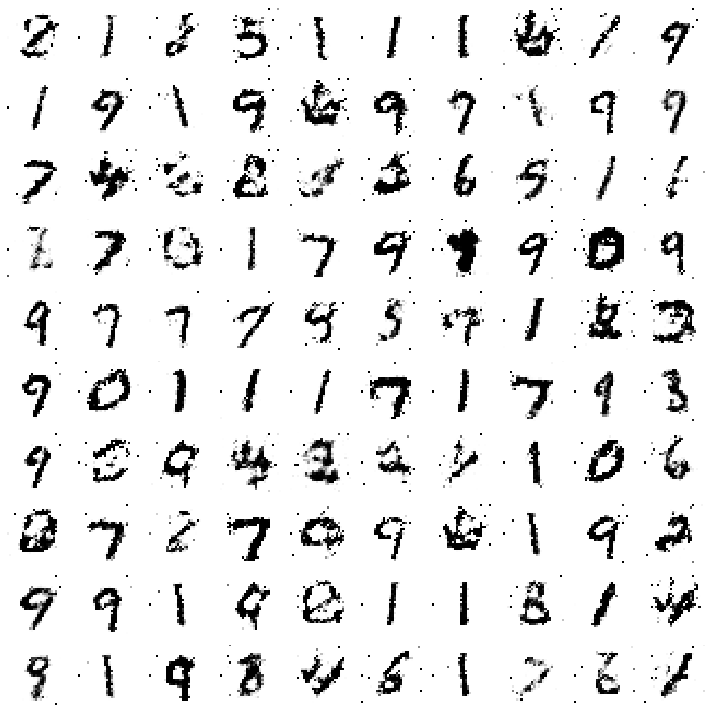

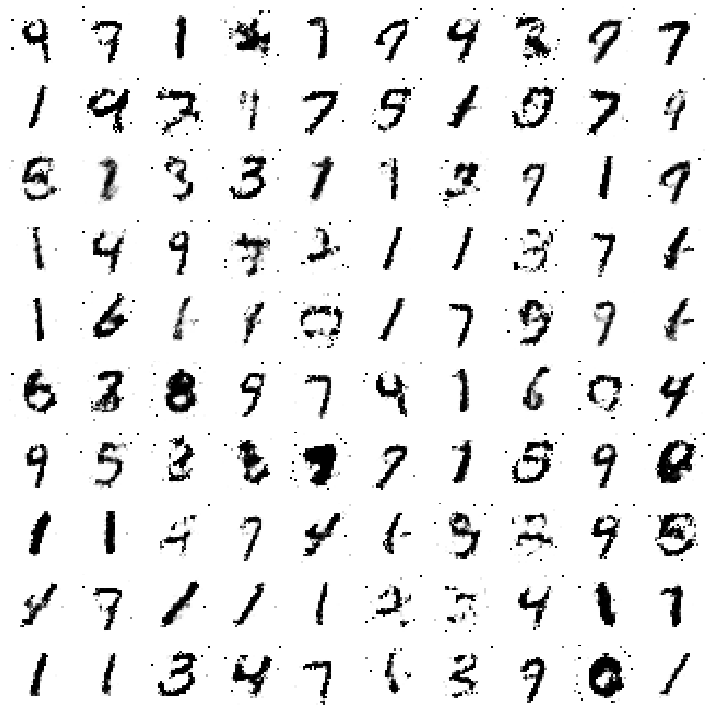

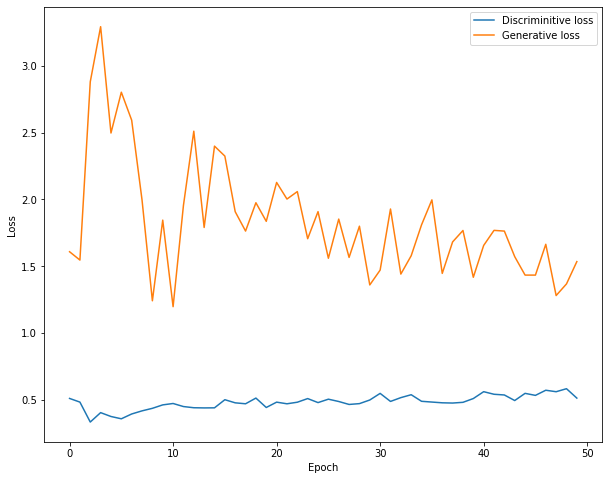

In [9]:
dLosses = []
gLosses = []
randomDim=10
model_complexity=256
train(50, 128, randomDim=10, model_complexity=256)

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 50
Batch size: 128
Batches per epoch: 468.75
randomDim:  100
--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:20, 22.71it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:20, 22.43it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:19, 23.72it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:20, 22.47it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:22, 21.04it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:22, 20.78it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:20, 22.42it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:20, 23.00it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:20, 22.84it/s]

--------------- Epoch 10 ---------------


  1%|          | 3/468 [00:00<00:20, 22.90it/s]

--------------- Epoch 11 ---------------


  0%|          | 2/468 [00:00<00:23, 19.62it/s]

--------------- Epoch 12 ---------------


  1%|          | 3/468 [00:00<00:21, 21.89it/s]

--------------- Epoch 13 ---------------


  1%|          | 3/468 [00:00<00:19, 23.62it/s]

--------------- Epoch 14 ---------------


  1%|          | 3/468 [00:00<00:20, 23.13it/s]

--------------- Epoch 15 ---------------


  1%|          | 3/468 [00:00<00:20, 22.17it/s]

--------------- Epoch 16 ---------------


  1%|          | 3/468 [00:00<00:19, 23.47it/s]

--------------- Epoch 17 ---------------


  0%|          | 2/468 [00:00<00:25, 18.01it/s]

--------------- Epoch 18 ---------------


  0%|          | 2/468 [00:00<00:26, 17.81it/s]

--------------- Epoch 19 ---------------


  1%|          | 3/468 [00:00<00:21, 22.06it/s]

--------------- Epoch 20 ---------------


  1%|          | 3/468 [00:00<00:20, 22.99it/s]

--------------- Epoch 21 ---------------


  0%|          | 2/468 [00:00<00:24, 18.94it/s]

--------------- Epoch 22 ---------------


  1%|          | 3/468 [00:00<00:22, 20.86it/s]

--------------- Epoch 23 ---------------


  1%|          | 3/468 [00:00<00:21, 22.04it/s]

--------------- Epoch 24 ---------------


  1%|          | 3/468 [00:00<00:20, 22.61it/s]

--------------- Epoch 25 ---------------


  1%|          | 3/468 [00:00<00:21, 21.72it/s]

--------------- Epoch 26 ---------------


  1%|          | 3/468 [00:00<00:19, 23.40it/s]

--------------- Epoch 27 ---------------


  1%|          | 3/468 [00:00<00:21, 21.73it/s]

--------------- Epoch 28 ---------------


  1%|          | 3/468 [00:00<00:20, 23.06it/s]

--------------- Epoch 29 ---------------


  1%|          | 3/468 [00:00<00:21, 21.18it/s]

--------------- Epoch 30 ---------------


  1%|          | 3/468 [00:00<00:20, 22.75it/s]

--------------- Epoch 31 ---------------


  1%|          | 3/468 [00:00<00:19, 23.34it/s]

--------------- Epoch 32 ---------------


  1%|          | 3/468 [00:00<00:21, 21.84it/s]

--------------- Epoch 33 ---------------


  1%|          | 3/468 [00:00<00:24, 18.93it/s]

--------------- Epoch 34 ---------------


  1%|          | 3/468 [00:00<00:20, 22.62it/s]

--------------- Epoch 35 ---------------


  1%|          | 3/468 [00:00<00:19, 23.75it/s]

--------------- Epoch 36 ---------------


  1%|          | 3/468 [00:00<00:19, 23.51it/s]

--------------- Epoch 37 ---------------


  1%|          | 3/468 [00:00<00:21, 21.72it/s]

--------------- Epoch 38 ---------------


  1%|          | 3/468 [00:00<00:19, 23.47it/s]

--------------- Epoch 39 ---------------


  1%|          | 3/468 [00:00<00:22, 20.91it/s]

--------------- Epoch 40 ---------------


  1%|          | 3/468 [00:00<00:21, 21.28it/s]

--------------- Epoch 41 ---------------


  1%|          | 3/468 [00:00<00:21, 21.49it/s]

--------------- Epoch 42 ---------------


  1%|          | 3/468 [00:00<00:20, 22.66it/s]

--------------- Epoch 43 ---------------


  1%|          | 3/468 [00:00<00:21, 22.04it/s]

--------------- Epoch 44 ---------------


  1%|          | 3/468 [00:00<00:19, 23.67it/s]

--------------- Epoch 45 ---------------


  1%|          | 3/468 [00:00<00:20, 22.38it/s]

--------------- Epoch 46 ---------------


  1%|          | 3/468 [00:00<00:21, 21.99it/s]

--------------- Epoch 47 ---------------


  0%|          | 2/468 [00:00<00:24, 18.88it/s]

--------------- Epoch 48 ---------------


  1%|          | 3/468 [00:00<00:20, 22.23it/s]

--------------- Epoch 49 ---------------


  1%|          | 3/468 [00:00<00:21, 21.92it/s]

--------------- Epoch 50 ---------------


100%|██████████| 468/468 [00:21<00:00, 22.01it/s]


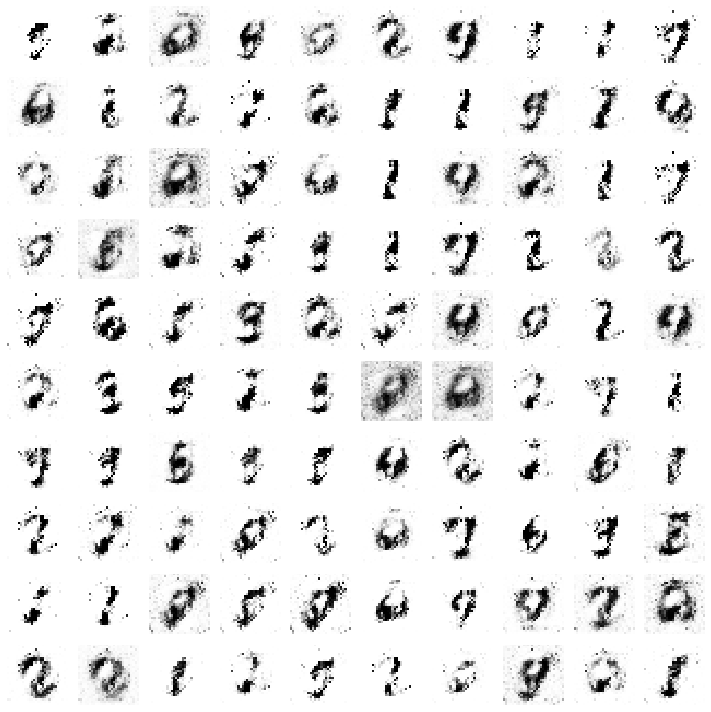

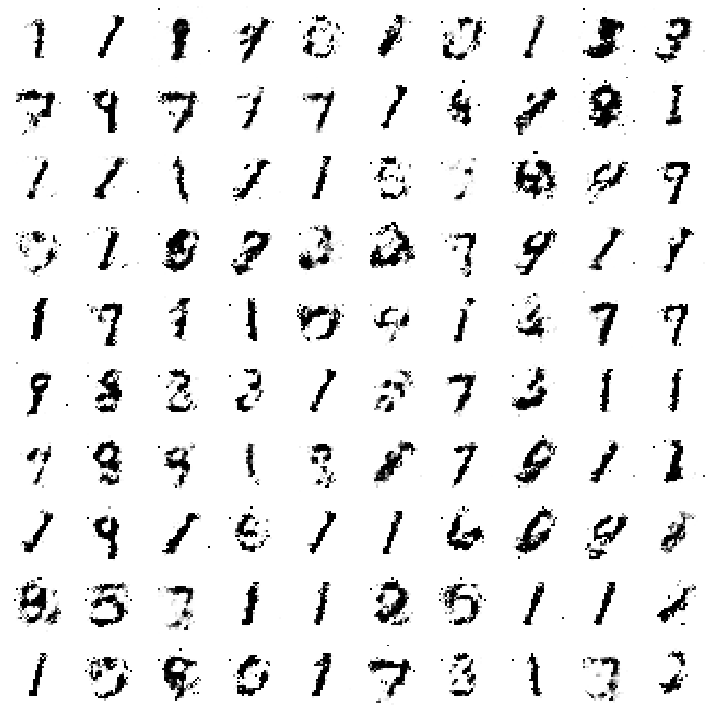

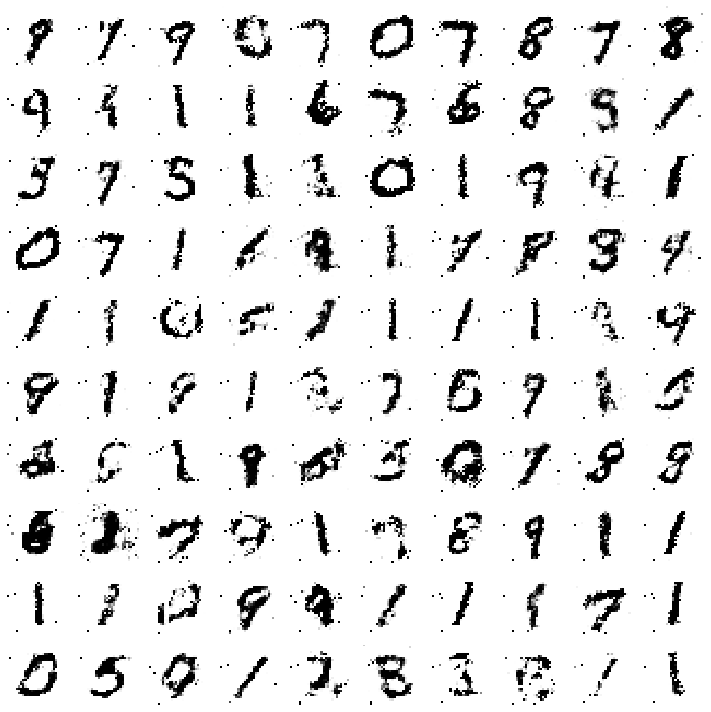

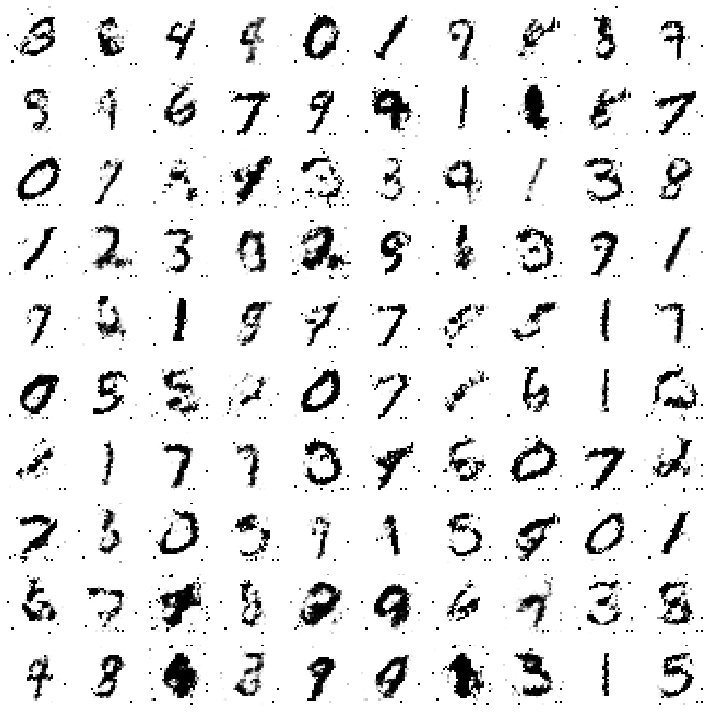

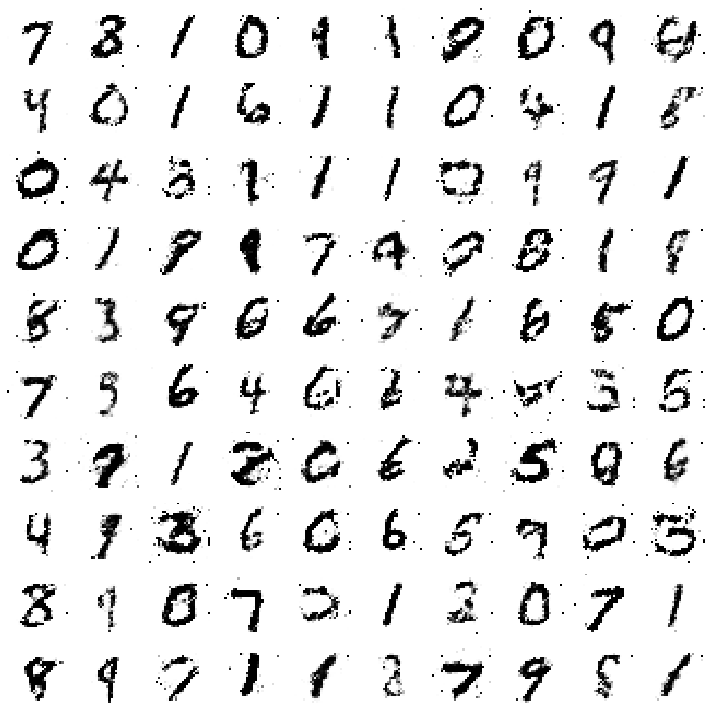

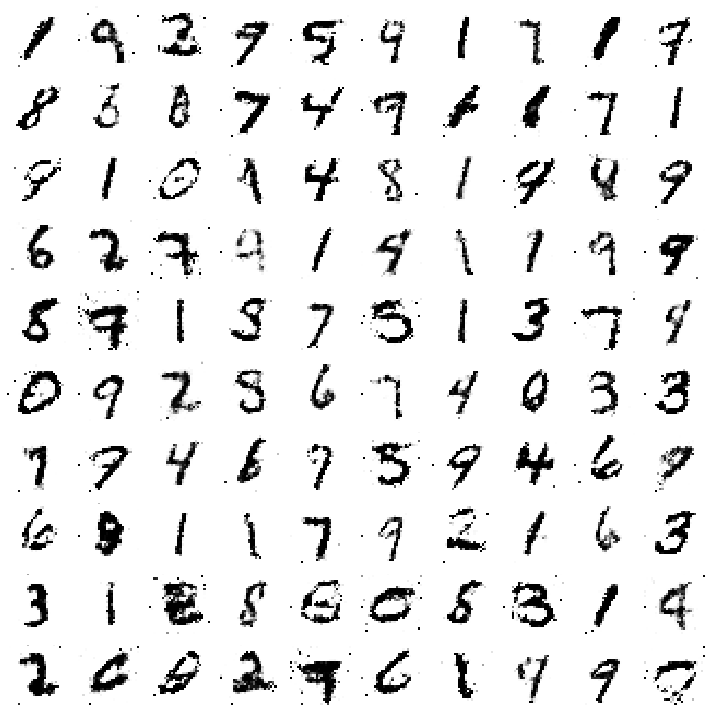

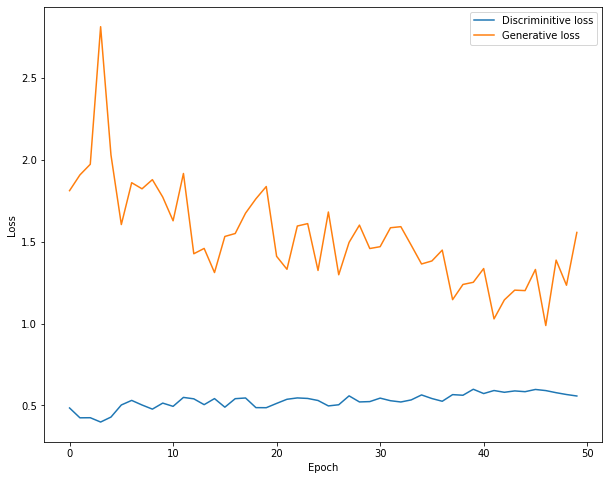

In [10]:
dLosses = []
gLosses = []
randomDim=100
model_complexity=256
train(50, 128, randomDim=randomDim, model_complexity=model_complexity)

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 50
Batch size: 128
Batches per epoch: 468.75
randomDim:  10
--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:22, 20.60it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:20, 22.88it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:20, 23.20it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:20, 22.37it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:21, 22.11it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/468 [00:00<00:24, 19.41it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:21, 21.47it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:21, 21.70it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:21, 21.84it/s]

--------------- Epoch 10 ---------------


  1%|          | 3/468 [00:00<00:20, 22.86it/s]

--------------- Epoch 11 ---------------


  0%|          | 2/468 [00:00<00:24, 18.94it/s]

--------------- Epoch 12 ---------------


  1%|          | 3/468 [00:00<00:21, 21.60it/s]

--------------- Epoch 13 ---------------


  1%|          | 3/468 [00:00<00:19, 23.27it/s]

--------------- Epoch 14 ---------------


  1%|          | 3/468 [00:00<00:21, 22.07it/s]

--------------- Epoch 15 ---------------


  1%|          | 3/468 [00:00<00:21, 21.27it/s]

--------------- Epoch 16 ---------------


  1%|          | 3/468 [00:00<00:20, 22.63it/s]

--------------- Epoch 17 ---------------


  0%|          | 2/468 [00:00<00:23, 19.62it/s]

--------------- Epoch 18 ---------------


  1%|          | 3/468 [00:00<00:21, 21.14it/s]

--------------- Epoch 19 ---------------


  1%|          | 3/468 [00:00<00:19, 23.83it/s]

--------------- Epoch 20 ---------------


  1%|          | 3/468 [00:00<00:20, 22.23it/s]

--------------- Epoch 21 ---------------


  1%|          | 3/468 [00:00<00:20, 22.92it/s]

--------------- Epoch 22 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 23 ---------------


  1%|          | 3/468 [00:00<00:22, 20.63it/s]

--------------- Epoch 24 ---------------


  1%|          | 3/468 [00:00<00:23, 19.49it/s]

--------------- Epoch 25 ---------------


  1%|          | 3/468 [00:00<00:20, 22.67it/s]

--------------- Epoch 26 ---------------


  1%|          | 3/468 [00:00<00:21, 21.62it/s]

--------------- Epoch 27 ---------------


  1%|          | 3/468 [00:00<00:20, 22.21it/s]

--------------- Epoch 28 ---------------


  1%|          | 3/468 [00:00<00:20, 22.97it/s]

--------------- Epoch 29 ---------------


  1%|          | 3/468 [00:00<00:19, 23.98it/s]

--------------- Epoch 30 ---------------


  1%|          | 3/468 [00:00<00:20, 22.77it/s]

--------------- Epoch 31 ---------------


  1%|          | 3/468 [00:00<00:19, 23.48it/s]

--------------- Epoch 32 ---------------


  1%|          | 3/468 [00:00<00:21, 21.53it/s]

--------------- Epoch 33 ---------------


  1%|          | 3/468 [00:00<00:21, 21.73it/s]

--------------- Epoch 34 ---------------


  1%|          | 3/468 [00:00<00:19, 23.60it/s]

--------------- Epoch 35 ---------------


  1%|          | 3/468 [00:00<00:20, 22.42it/s]

--------------- Epoch 36 ---------------


  1%|          | 3/468 [00:00<00:21, 21.92it/s]

--------------- Epoch 37 ---------------


  1%|          | 3/468 [00:00<00:19, 23.78it/s]

--------------- Epoch 38 ---------------


  1%|          | 3/468 [00:00<00:22, 20.97it/s]

--------------- Epoch 39 ---------------


  1%|          | 3/468 [00:00<00:20, 23.06it/s]

--------------- Epoch 40 ---------------


  1%|          | 3/468 [00:00<00:19, 23.77it/s]

--------------- Epoch 41 ---------------


  1%|          | 3/468 [00:00<00:20, 22.55it/s]

--------------- Epoch 42 ---------------


  1%|          | 3/468 [00:00<00:20, 22.90it/s]

--------------- Epoch 43 ---------------


  0%|          | 2/468 [00:00<00:23, 19.49it/s]

--------------- Epoch 44 ---------------


  1%|          | 3/468 [00:00<00:19, 23.35it/s]

--------------- Epoch 45 ---------------


  1%|          | 3/468 [00:00<00:20, 22.41it/s]

--------------- Epoch 46 ---------------


  1%|          | 3/468 [00:00<00:20, 22.55it/s]

--------------- Epoch 47 ---------------


  1%|          | 3/468 [00:00<00:20, 23.18it/s]

--------------- Epoch 48 ---------------


  1%|          | 3/468 [00:00<00:19, 23.50it/s]

--------------- Epoch 49 ---------------


  0%|          | 2/468 [00:00<00:23, 19.59it/s]

--------------- Epoch 50 ---------------


100%|██████████| 468/468 [00:21<00:00, 21.64it/s]


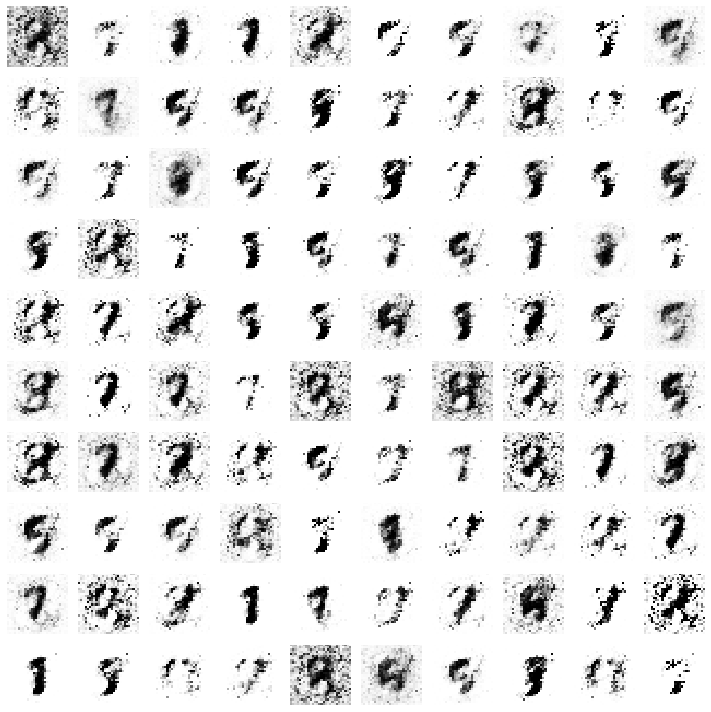

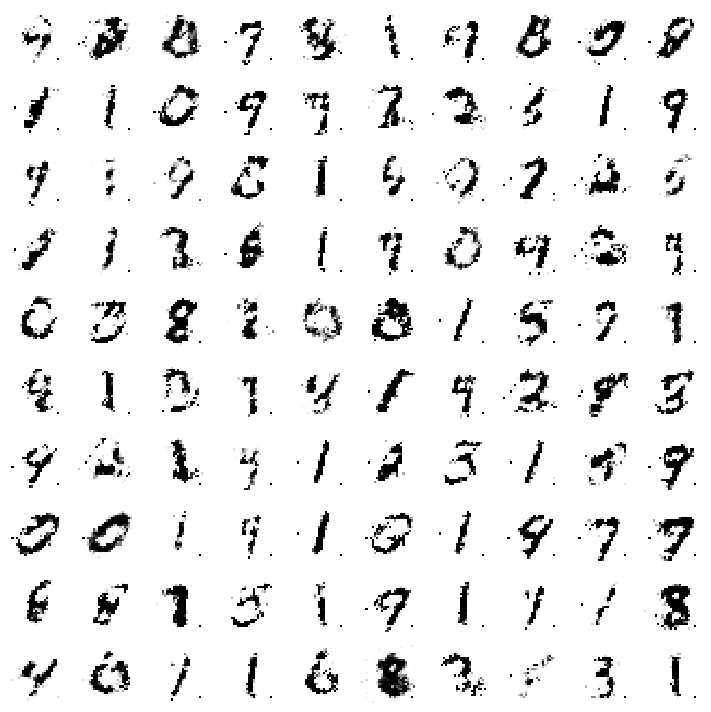

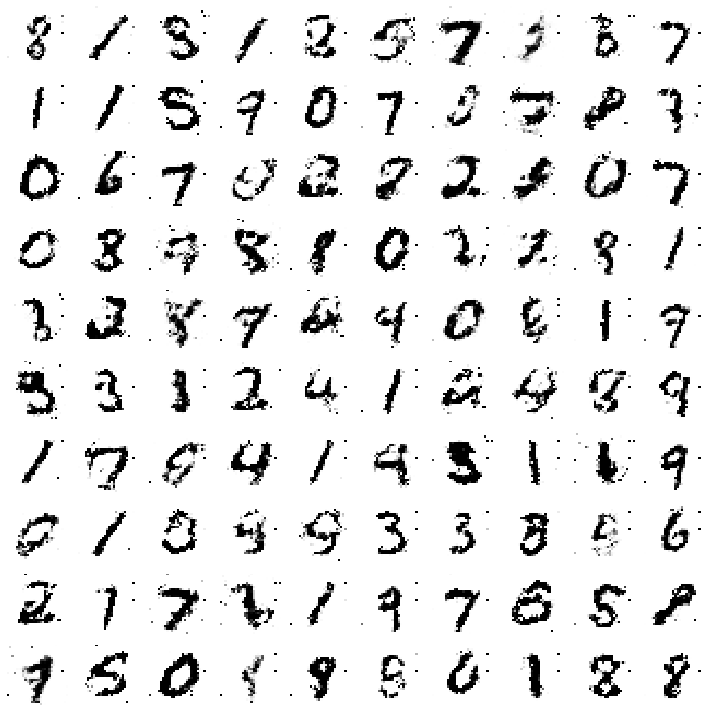

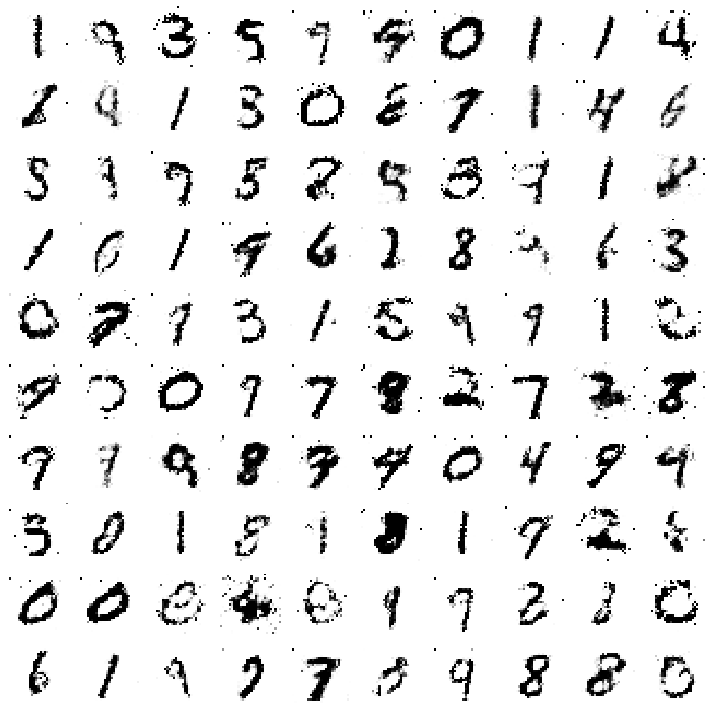

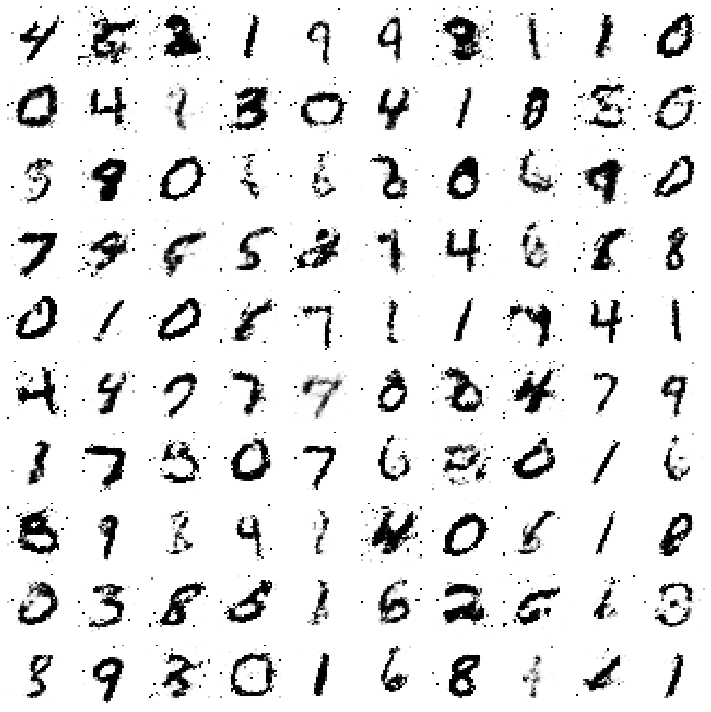

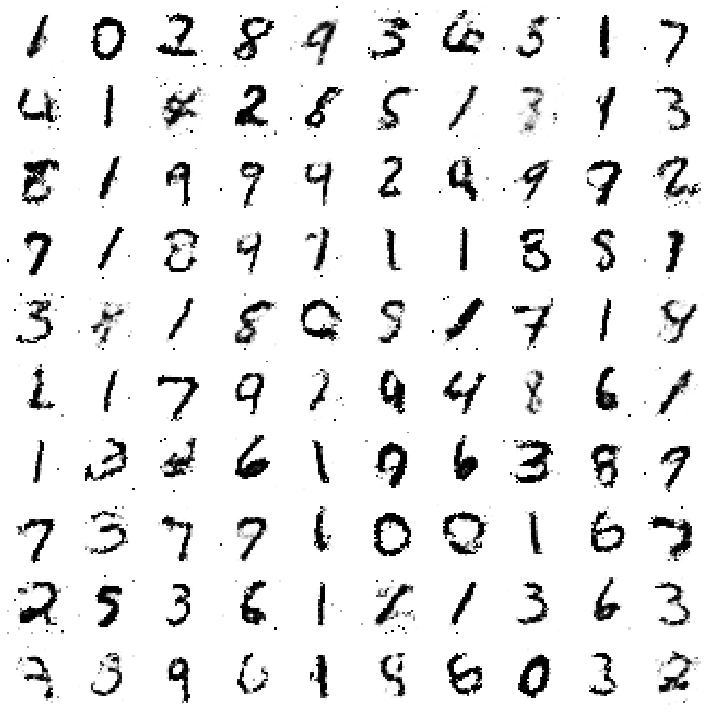

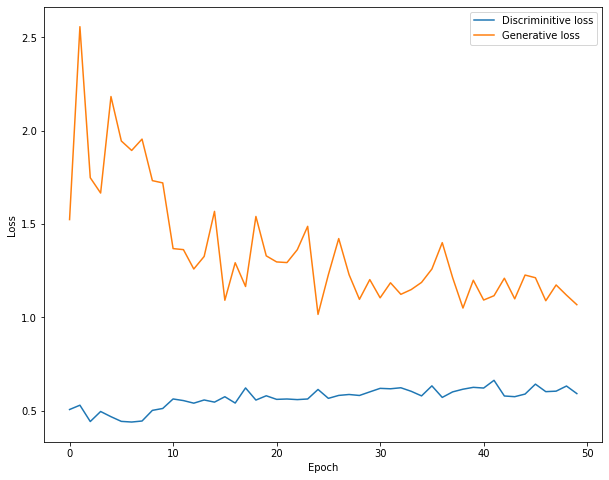

In [11]:
dLosses = []
gLosses = []
randomDim=10
model_complexity=1024
train(50, 128, randomDim=randomDim, model_complexity=model_complexity)